# Twitter User Gender Classification

With the increase in the use of social media, Twitter has become one of the major tool for studying social networking. Using data collected from the Twitter, researchers can understand the public opinion, monitor advancement of a disease or improve response to natural catastrophe's. 

Eventhough data collected from Twitter is widely used, there are som personal information about the user like the gender of the user is never provided or collected by Twitter. This implies that Twitter does not require users to reveal much of their personal identity. When a new user creates an account on Twitter, the only required field is the username; gender of the user is never asked. Similarly, when the data is collected from the Twitter, gender of the user is not provided.

However, for understanding the social, demographic and psychological studies of the society communities, it is important to have the gender information. By accurately predicting the demographic attributes from social media and informal online content, it gets easier to personalize marketing and advertising content to the target consumers.

## Goal of the Project: 
    
  __Identify features which can help to determine Twitter user's gender (Male, Female, Brand) with atleast 60% accuracy__

I will try to answer following questions:
1. How well does tweets and profiles predict users gender?
2. How well do stylistic factors (like link_color and sidebar_color) predict user gender?

## About the data

The dataset was provided by Data for Everyone Library on Crowdflower.

This dataset contains 20,000 rows and 26 columns. Each row containing user name, random tweet, account profile image, location along with link and sidebar color.

Below are the metadata of each field the dataset contains. Also, out of these 26 columns, I am interested in understanding the relationship of the attributes description, text, link_color and sidebar_color (marked in bold below) in predicting the user's gender.

- _unit_id: A unique id for user
- _golden: Whether the user was included in the gold standard for the model. It contains True or False values.
- _unit_state: Defines the state of the observation. It contains 2 categories - finalized (for contributor-judged) and golden (for gold standard observations)
- _trusted_judgements: Number of trusted judgements (int). 3 for non-golden and unique id for gold standard observations.
- _last_judgement_at: date and time of the last contributor judgement. It contains blank for gold standard observations.
- __gender: It contains 3 categories male, female or brand (for non-human profiles)__
- __gender:confidence: This field contains float value that represents confidence in the provided gender.__
- profile_yn: It contains two categories - yes and no. 'no' means that the profile was part of the dataset but was not available when contributors went to judge it. This field contains 'yes' for gold standard observations.
- profile_yn:confidence: Confidence in the existence/non-existence of the profile
- created: date and time when the profile was created.
- __description: the user's profile description__
- fav_number: number of tweets the user has favorited
- gender_gold: if the profile is golden then what is the gender?
- __link_color: the link color of the profile as a hex value__
- name: the user's name
- profile_yn_gold: Whether the profile y/n value is golden
- profileimage: a link to the profile image
- retweet_count: number of times the user has retweeted (or possibly, been retweeted)
- __sidebar_color: color of the profile sidebar, as a hex value__
- __text: text of a random one of the user's tweets.__
- tweet_coord: if the user has location turned on, the coordinates as a string with the format latitude, longitude
- tweet_count: number of tweets that the user has posted
- tweet_created: when the random tweet (in the text column) was created
- tweet_id: the tweet id of the random tweet
- tweet_location: location of the tweet
- user_timezone: the timezone of the user.

## Loading libraries

In [4]:
import pandas as pd
import numpy as np
import re
import unicodedata
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline


from bokeh.plotting import output_notebook, figure, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import linear_model, metrics
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from cytoolz import identity
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

## Data Encoding

'latin-1' encoding is used because in the text and description columns contain special characters like (é,Û,Ï, etc) which do not fit in default UTF-8 

## Loading Dataset

Reading the gender classifier file which was provided on Kaggle into a variable using pandas and encoding the dataframe to latin-1 

In [170]:
data = pd.read_csv('D:/Nikita/Ling583/gender-classifier-DFE-791531.csv', encoding = 'latin-1')

In [171]:
# displaying first 5 rows of the dataframe
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229096808449/fYvzqXN7_normal.png,0,FFFFFF,Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221532700673/WW16tBbU_normal.jpeg,0,C0DEED,ÛÏIt felt like they were my friends and I was living the story with themÛ https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418249658368/SBLCXdF7_normal.png,1,C0DEED,i absolutely adore when louis starts the songs it hits me hard but it feels good,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936/IMG_8444_normal.JPG,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you use @IFTTT?! Don't typically see an advanced user on the @PGATOUR! https://t.co/H68ou5PE9L,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871032446976/AOfpk-mr_normal.jpeg,0,0,Watching Neighbours on Sky+ catching up with the Neighbs!! Xxx _Ù÷Ä_Ù÷Ä_Ù÷Ä_ÙÔÎ_ÙÈ_ÙÔ_ÙÈ Xxx,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


## Checking the features for missing values

In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
_unit_id                 20050 non-null int64
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
_last_judgment_at        20000 non-null object
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
created                  20050 non-null object
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
profileimage             20050 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text    

As most of the columns are not relevant for predicting the gender of the user, I will focus on the following features:
- link_color
- sidebar_color
- text
- description
- gender
- gender:confidence

It can be observed that the description, gender and gender:confidence have some missing values.

In [173]:
data['gender:confidence'].value_counts()

1.0000    13926
0.0000    71   
0.6691    31   
0.6709    30   
0.6591    30   
0.6667    30   
0.6619    29   
0.6686    27   
0.6743    27   
0.6769    26   
0.6666    25   
0.6678    24   
0.6715    24   
0.6707    24   
0.6561    24   
0.6752    24   
0.6642    24   
0.6656    24   
0.6609    23   
0.6675    23   
0.6685    22   
0.6766    22   
0.6645    22   
0.6741    22   
0.6711    22   
0.6774    22   
0.6706    21   
0.6659    21   
0.6664    21   
0.6739    21   
          ..   
0.3468    1    
0.6955    1    
0.6323    1    
0.3544    1    
0.3337    1    
0.3283    1    
0.3557    1    
0.3575    1    
0.3622    1    
0.3269    1    
0.6986    1    
0.3343    1    
0.3339    1    
0.3307    1    
0.6931    1    
0.3628    1    
0.3319    1    
0.3378    1    
0.8458    1    
0.6961    1    
0.6059    1    
0.3335    1    
0.3722    1    
0.3613    1    
0.3461    1    
0.6379    1    
0.6322    1    
0.6911    1    
0.6971    1    
0.6873    1    
Name: gender:confidence,

About 13926 gender categories which were classified by CrowdFlower AI(organization that provided the dataset to Kaggle) out of 20,050 were with 100% confidence. Hence, in order to predict the gender of the users I would be using only those genders who have 100% confidence level.

In [174]:
data['gender'].value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

As we can see that there are 4 categories which exists in the gender feature. I am focusing this project in classifying whether the user is female, male or brand. I am not considering unknown category of gender because it is lesser in count and it doesn't provide much information about the user.

## Data Exploration

## 1.  Link_Color and Sidebar_Color Features Exploration

On Twitter, user can personalize their account by changing the colors of their links or their sidebars.

__Assumption__: There is a pattern in which people from different genders personalize their page differently. 

Eg. Female use pink color on the links or the sidebar. And Male use blue color on the links or the sidebar.


I would be exploring on two features link_color and sidebar_color for three categories of the gender (Male, Female and Brand).

In [175]:
# Defining the function to return values from link_color and sidebar_color for each gender category
def plot_color_features(data, feature, toRemove):
    # Selecting columns from the data
    df_col = data.loc[:, ['gender:confidence', 'gender', feature]]
    
    # Selecting rows where gender:confidence >= 1 and removing values like 7.60E+42
    dfcolFiltered = df_col[(df_col['gender:confidence'] >= 1) &
                         ((df_col[feature]).str.contains('E\+') != True)]
    
    # Segregating data based on the gender category
    Male_data = dfcolFiltered[dfcolFiltered['gender'] == 'male']
    Female_data = dfcolFiltered[dfcolFiltered['gender'] == 'female']
    Brand_data = dfcolFiltered[dfcolFiltered['gender'] == 'brand']
    
    # To plot the graph, I need top 20 colors along with its count for each gender category
    color_male = Male_data[feature]
    color_female = Female_data[feature]
    color_brand = Brand_data[feature]
    
    # Creating list of lists by using flatten method
    male_list = list(color_male.values.flatten())
    female_list = list(color_female.values.flatten())
    brand_list = list(color_brand.values.flatten())
    
    # Only Selecting top 20 colors used by each gender and creating a list which includes the color and the count
    color_male = Counter(color_male).most_common(21)
    color_female = Counter(color_female).most_common(21)
    color_brand = Counter(color_brand).most_common(21)
    
    # Taking list of colors for each gender category
    # Not selecting the first most common color from each of the gender category
    male_colors = [x[0] for x in color_male[toRemove:]] 
    female_colors = [x[0] for x in color_female[toRemove:]] 
    brand_colors = [x[0] for x in color_brand[toRemove:]]
    
    # Taking list of counts for each gender category
    # Not Selecting the first most common number because the most common color is blue for all the categories and it doesnt give much value
    male_num = [x[1] for x in color_male[toRemove:]] 
    female_num = [x[1] for x in color_female[toRemove:]] 
    brand_num = [x[1] for x in color_brand[toRemove:]]
    
    # Converting hex codes into consistent format
    # 1. Prefixing hex code with # and adding six zeros to it
    # 2. Selecting 6 characters from the newly converted hex code
    Hexcolor_Male = ['#' + x + '000000' for x in male_colors]
    Hexcolor_Male = [x[0:7] for x in Hexcolor_Male]
    Hexcolor_Female = ['#' + x + '000000' for x in female_colors]
    Hexcolor_Female = [x[0:7] for x in Hexcolor_Female]
    Hexcolor_Brand = ['#' + x + '000000' for x in brand_colors]
    Hexcolor_Brand = [x[0:7] for x in Hexcolor_Brand]
    
    return male_num, female_num, brand_num, Hexcolor_Male, Hexcolor_Female, Hexcolor_Brand

### A. Exploring link_color attribute for each of the gender category

In [176]:
# calling function plot_color_features and removing 1 most common occuring color from each category
male_num, female_num, brand_num, Hexcolor_Male, Hexcolor_Female, Hexcolor_Brand = plot_color_features(data, 'link_color', 1)

In [177]:
col_range = list(range(len(male_num)))

#### Plotting the graph of the link_color for the Male gender 

Text(0.5,1,'Link Colors which Male gender prefer ')

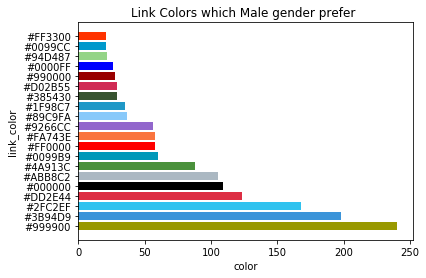

In [178]:
plt.barh(col_range,male_num,
                label = 'Male', color = Hexcolor_Male)
plt.yticks(col_range, Hexcolor_Male)
plt.xlabel('color')
plt.ylabel('link_color')
plt. title('Link Colors which Male gender prefer ')

#### Plotting the graph of the link_color for the Female gender 

Text(0.5,1,'Link Colors which Female gender prefer')

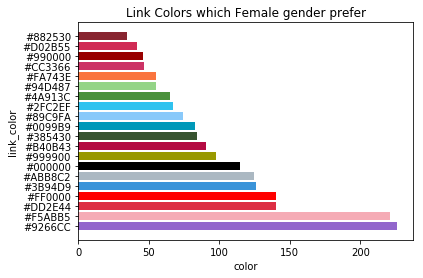

In [179]:
plt.barh(col_range,female_num,
                label = 'Female', color = Hexcolor_Female)
plt.yticks(col_range, Hexcolor_Female)
plt.xlabel('color')
plt.ylabel('link_color')
plt. title('Link Colors which Female gender prefer')

#### Plotting the graph of the link_color for the Brand gender 

Text(0.5,1,'Link Colors which Brand gender prefer')

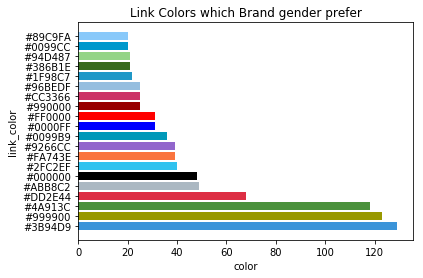

In [180]:
plt.barh(col_range,brand_num,
                label = 'Brand', color = Hexcolor_Brand)
plt.yticks(col_range, Hexcolor_Brand)
plt.xlabel('color')
plt.ylabel('link_color')
plt. title('Link Colors which Brand gender prefer')

### B. Exploring sidebar_color for each of the gender category

In [181]:
# calling function plot_color_features and removing 4 most common occuring color from each category
male_num_sc, female_num_sc, brand_num_sc, Hexcolor_Male_sc, Hexcolor_Female_sc, Hexcolor_Brand_sc = plot_color_features(data, 'sidebar_color', 4)

In [182]:
col_range_sc = list(range(len(male_num_sc)))

#### Plotting the graph of the side_color for the Male gender 

Text(0.5,1,'Sidebar colors which Male gender prefer')

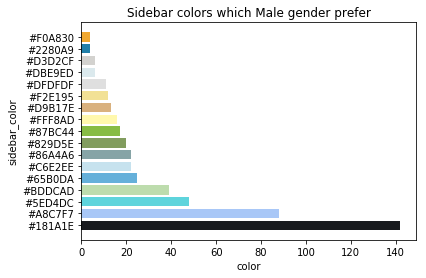

In [183]:
plt.barh(col_range_sc,male_num_sc,
                label = 'Male', color = Hexcolor_Male_sc)
plt.yticks(col_range_sc, Hexcolor_Male_sc)
plt.xlabel('color')
plt.ylabel('sidebar_color')
plt. title('Sidebar colors which Male gender prefer')

#### Plotting the graph of the sidebar_color for the Female gender 

Text(0.5,1,'Sidebar colors which Female gender prefer')

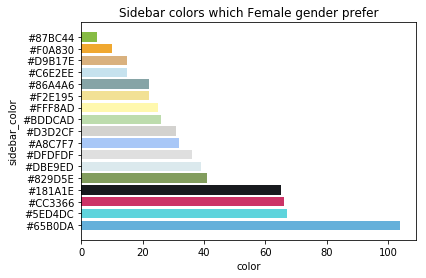

In [184]:
plt.barh(col_range_sc,female_num_sc,
                label = 'Female', color = Hexcolor_Female_sc)
plt.yticks(col_range_sc, Hexcolor_Female_sc)
plt.xlabel('color')
plt.ylabel('sidebar_color')
plt. title('Sidebar colors which Female gender prefer')

#### Plotting the graph of the sidebar_color for the Brand gender 

Text(0.5,1,'Sidebar colors which Brand gender prefer')

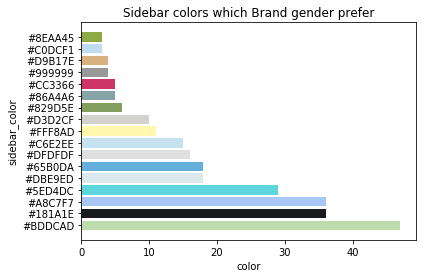

In [185]:
plt.barh(col_range_sc,brand_num_sc,
                label = 'Brand', color = Hexcolor_Brand_sc)
plt.yticks(col_range_sc, Hexcolor_Brand_sc)
plt.xlabel('color')
plt.ylabel('sidebar_color')
plt. title('Sidebar colors which Brand gender prefer')

__Observations from the Colors Features exploration__
1. Female prefer pink and purple as their link_color
2. Male prefer green and blue as their link_color
3. Brand prefer blue or green as their link_color
4. Users change link color more than the side bar color

## 2. Text and Description Features Exploration

Exploring which words are mostly used by each gender category (Male, Female and Brand). I would be exploring two attributes of the dataset - text from user description and text from tweets.

Description field contains description of the user's profile. This field contains 3744 values as NaN (ie. Not a Number). It would cause problem while trying to clean 'description' field. Therefore changing NaN to blank (ie. '') 

In [186]:
data.description = data.description.fillna('')

### Data Cleaning

In order to explore the texts, it is necessary to normalize the text. I would follow below steps for cleaning the texts.
1. Normalize the text into lowercase
2. Remove punctuations
3. Remove numbers
4. Remove double spaces
5. Remove hyperlinks

In [187]:
import string
def clean(s):
    s = str(s)        # Converting to string
    s = s.lower()     # Normalizing text by converting everything to lower case
    
    # Removing characters that are non-alphanumeric
    s = re.sub('https://t.co/\w+', ' ',s)
    s = re.sub('\s\W',' ',s) # Replacing one whitespace followed by one non-alphanumeric character with ' '
    s = re.sub('\W,\s', ' ', s) # Replacing one non-alphanumeric character  followed by comma and one whitespace with ' '
    s = re.sub("\d+",' ',s)     # Removing 1 or more digits
    s = re.sub('\s+', ' ', s)   # Removing 1 or more spaces from the text
    s = re.sub('[!#?$@_%]', ' ', s) # Removing !, @, #, $, _ from the string
    s = s.replace(',', ' ')
    s = s.replace('[\W*]', ' ')
    return s

In [188]:
data['text_normalized'] = [clean(text) for text in data['text']]
data['desc_normalized'] = [clean(desc) for desc in data['description']] 

In [189]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

data['text_normalized']

0        robbie e responds to critics after win against eddie edwards in the worldtitleseries                                                      
1        ûïit felt like they were my friends and i was living the story with themû retired ian                                                  
2        i absolutely adore when louis starts the songs it hits me hard but it feels good                                                          
3        hi jordanspieth looking at the url do you use ifttt   don't typically see an advanced user on the pgatour                                 
4        watching neighbours on sky+ catching up with the neighbs   xxx  ù÷ä ù÷ä ù÷ä ùôî ùè ùô ùè xxx                                           
5        ive seen people on the train with lamps  chairs  tvs etc                                                                                  
6         bpackengineer thank you for your patience while we take care of the issue                             

In [293]:
data[data['link_color'].str.contains('E\+') == True]['link_color'].shape

(34,)

In [281]:
# Putting all the interesting text together, 
# i.e. the profile description and the tweets itself in one string for each user
dfText = data
dfText['all_text'] =dfText['text_normalized'].str.cat(dfText['desc_normalized'],sep=' ')

# Selecting rows where the confidence in gender is 1 and gender categories are female, male and brand
# Since link_Color column contains values like 2.21E+09. Hence eliminating such values
dfText = dfText[(dfText['gender:confidence']==1)&(dfText['gender']!='unknown')]#&(dfText['link_color'].str.contains('E\+') != True)]

In [282]:
dfText.shape

(13804, 29)

In [283]:
male = dfText[dfText['gender'] == 'male']
female = dfText[dfText['gender'] == 'female']
brand = dfText[dfText['gender'] == 'brand']

### Tokenization

To visualize the most frequent words used by each category of gender, it is necessary to tokenize the cleaned text. For the tokenization task, I will use CountVectorizer in order to create bag of words. Also, I will remove stopwords and unicodes from the bag of words in order to get some words which makes sense.

In [284]:
cvec = CountVectorizer(stop_words='english', strip_accents = 'unicode')

In [285]:
male.shape

(4653, 29)

### Gender: Male

#### Plotting the graph of the most frequent words used by Male gender based on the all_text 

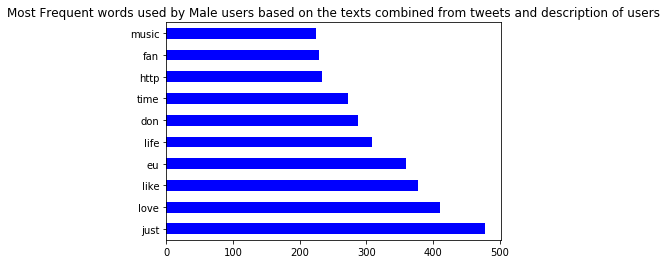

In [298]:
cvec.fit(male['all_text'])

male_df = pd.DataFrame(cvec.transform(male['all_text']).todense(),
                      columns = cvec.get_feature_names())
male_word_counts = male_df.sum(axis=0)
male_word_counts.sort_values(ascending=False).head(20)
male_word_counts.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Male users based on the texts combined from tweets and description of users',color= 'blue')

#### Plotting the graph of the most frequent words used by Male gender based on the profile description of the user

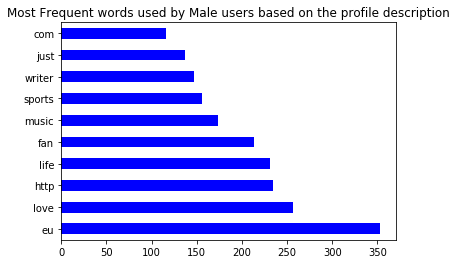

In [299]:
cvec.fit(male['desc_normalized'])

male_df_desc = pd.DataFrame(cvec.transform(male['desc_normalized']).todense(),
                      columns = cvec.get_feature_names())
male_word_counts_desc = male_df_desc.sum(axis=0)
male_word_counts_desc.sort_values(ascending=False).head(20)
male_word_counts_desc.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Male users based on the profile description', color = 'blue')


#### Plotting the graph of the most frequent words used by Male gender based on the tweets posted by the user

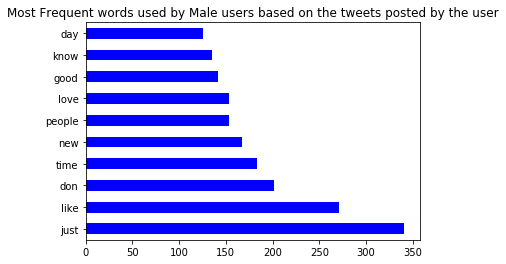

In [300]:
cvec.fit(male['text_normalized'])

male_df_text = pd.DataFrame(cvec.transform(male['text_normalized']).todense(),
                      columns = cvec.get_feature_names())
male_word_counts_text = male_df_text.sum(axis=0)
male_word_counts_text.sort_values(ascending=False).head(20)
male_word_counts_text.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Male users based on the tweets posted by the user', color = 'blue')


### Gender: Female

#### Plotting the graph of the most frequent words used by Female gender based on the all_text 

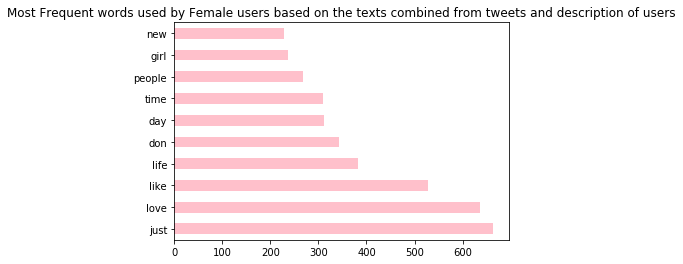

In [304]:
cvec.fit(female['all_text'])

female_df = pd.DataFrame(cvec.transform(female['all_text']).todense(),
                      columns = cvec.get_feature_names())
female_word_counts = female_df.sum(axis=0)
female_word_counts.sort_values(ascending=False).head(20)
female_word_counts.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Female users based on the texts combined from tweets and description of users', color = 'pink')


#### Plotting the graph of the most frequent words used by Female gender based on the profile description of the user

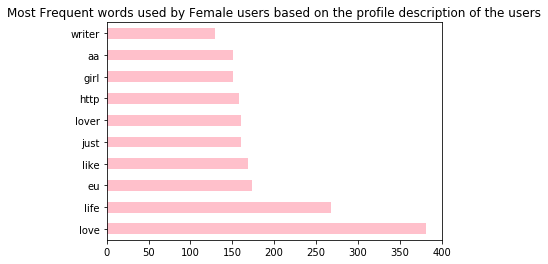

In [302]:
cvec.fit(female['desc_normalized'])

female_df_desc = pd.DataFrame(cvec.transform(female['desc_normalized']).todense(),
                      columns = cvec.get_feature_names())
female_word_counts_desc = female_df_desc.sum(axis=0)
female_word_counts_desc.sort_values(ascending=False).head(20)
female_word_counts_desc.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Female users based on the profile description of the users', color = 'pink')

#### Plotting the graph of the most frequent words used by Female gender based on the tweets posted by the user

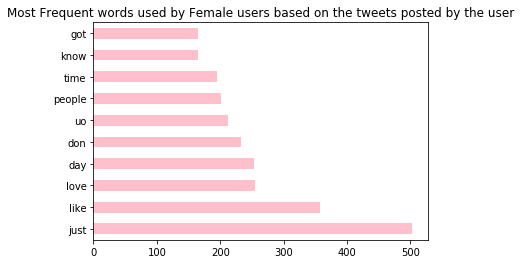

In [306]:
cvec.fit(female['text_normalized'])

female_df_text = pd.DataFrame(cvec.transform(female['text_normalized']).todense(),
                      columns = cvec.get_feature_names())
female_word_counts_text = female_df_text.sum(axis=0)
female_word_counts_text.sort_values(ascending=False).head(20)
female_word_counts_text.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Female users based on the tweets posted by the user', color= 'pink')


### Gender: Brand

#### Plotting the graph of the most frequent words used by Brand based on the all_text 

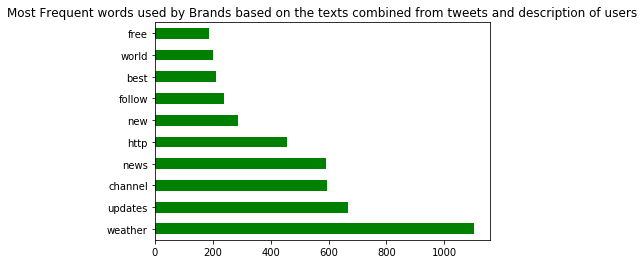

In [307]:
cvec.fit(brand['all_text'])

brand_df = pd.DataFrame(cvec.transform(brand['all_text']).todense(),
                      columns = cvec.get_feature_names())
brand_word_counts = brand_df.sum(axis=0)
brand_word_counts.sort_values(ascending=False).head(20)
brand_word_counts.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Brands based on the texts combined from tweets and description of users', color = 'green')


#### Plotting the graph of the most frequent words used by Brand based on the profile description of the user

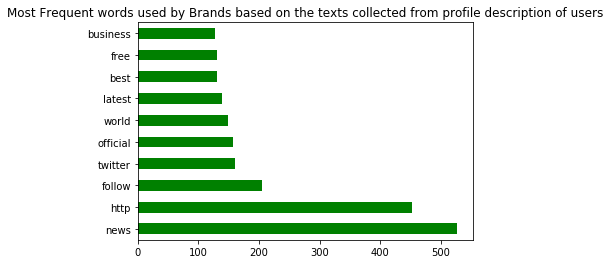

In [308]:
cvec.fit(brand['desc_normalized'])

brand_df_desc = pd.DataFrame(cvec.transform(brand['desc_normalized']).todense(),
                      columns = cvec.get_feature_names())
brand_word_counts_desc = brand_df_desc.sum(axis=0)
brand_word_counts_desc.sort_values(ascending=False).head(20)
brand_word_counts_desc.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Brands based on the texts collected from profile description of users', color = 'green')

#### Plotting the graph of the most frequent words used by Brands based on the tweets posted by the user

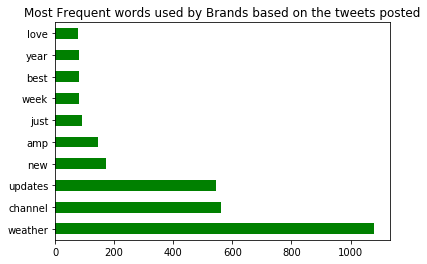

In [309]:
cvec.fit(brand['text_normalized'])

brand_df_text = pd.DataFrame(cvec.transform(brand['text_normalized']).todense(),
                      columns = cvec.get_feature_names())
brand_word_counts_text = brand_df_text.sum(axis=0)
brand_word_counts_text.sort_values(ascending=False).head(20)
brand_word_counts_text.sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                             title = 'Most Frequent words used by Brands based on the tweets posted', color= 'green')


__Observations:__
1. The results from the text features exploration are not quite conclusive when compared with results obtained from the colors features exploration.
2. Most used words used by male and female gender, are very similar words such as "just", "like", "love" which this does not give us any information about the gender really. 
3. One interesting thing that can be noticed is that the brands tends to use the words "weather", "channel" and "news" more than regular male and female users. This means that we have probably many information or weather channels accounts in our dataset. Another interesting fact is on the usage of the word "https". It seems like brands tend to post more links than standard users.

## Data Modeling

I will use machine learning algorithms to predict the user's gender based on color features and text features.
For the data modelling phase of the project, I will perform below steps

1. Creating dummy variables for gender attribute in the dataset.
2. Splitting data into training and test set by using 70:30
3. I will run following models on the training data and predicting on the test data
    - SVC()
    - KNeighborsClassifier()
    - RandomForestClassifier()
    - LogisticRegression()
    - MultinomialNB()
4. Evaluate model based on Accuracy.

In [226]:
# following models will be used to train our dataset
models = [linear_model.LogisticRegression(),
          naive_bayes.MultinomialNB(),
          RandomForestClassifier(n_estimators=50),
          KNeighborsClassifier(),
          SVC()]

In [227]:
# eval_model function trains the classifier using training dataset, predicts on test set and returns accuracy for the model on the test.
def eval_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = model.score(x_test,y_test)
    return acc

In [353]:
## Defining a function for tokenization where I am removing the stopwords and unicodes from the tokens
def bag_of_words_cal(text):
    vectorizer = CountVectorizer(stop_words='english',
                                  strip_accents = 'unicode')
    vectors = vectorizer.fit_transform(text)
    #vocabulary = vectorizer.get_feature_names()
    return vectors#, vocabulary

### How well do stylistic factors (like link_color and sidebar_color) predict user gender?

### A. Evaluating the relationship between link_color and user's gender

In [354]:
from sklearn import linear_model, metrics
from sklearn import naive_bayes
from sklearn.pipeline import make_pipeline

# Using feature link_color as we saw from the visualizations that users tend to change link_color more than the sidebar color
df_col = data.loc[:, ['gender:confidence', 'gender', 'link_color']]#, 'sidebar_color']]

# Selecting rows where gender:confidence >= 1 and removing values like 7.60E+42
dfcolFiltered = df_col[(df_col['gender:confidence'] >= 1) & ((df_col['link_color']).str.contains('E\+') != True)]

bow = bag_of_words_cal(dfcolFiltered['link_color'])
X = bow
 
y = LabelEncoder().fit_transform(dfcolFiltered['gender'])

# Listing the classifiers I want to test the data on


In [216]:
X.shape

(13900, 2290)

In [217]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state = 123)

In [218]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(9730, 2290)
(4170, 2290)
(9730,)
(4170,)


#### Baseline Model - link_color

Calculating the baseline model by predicting the most frequently occuring gender class in the dataset. 

In [219]:
base_model = make_pipeline(CountVectorizer(analyzer=identity), DummyClassifier('most_frequent'))     
base_score = cross_val_score(base_model,dfcolFiltered['link_color'], 
                             dfcolFiltered['gender'], cv=5, n_jobs=-1)

In [220]:
base_score.mean()

0.3854676480077915

The accuracy of baseline model is 38.54% 

#### Results for link_color feature

In [229]:
results_lc =  pd.Series([eval_model(model) for model in models], 
                     index = ['logit', 'nb', 'rf', 'knn', 'svc'])

In [230]:
print(results_lc)

logit    0.410920
nb       0.403257
rf       0.411159
knn      0.349856
svc      0.385297
dtype: float64


It seems that Logistic Regression model is performing better when link_color feature is used to predict the gender.

#### Plotting the bar plot for accuracies obtained for link_color feature

In [310]:
mse_model = []
acc_model = []
for i in range(5):
    acc = results_lc[i]
    acc_model.append(acc)
    

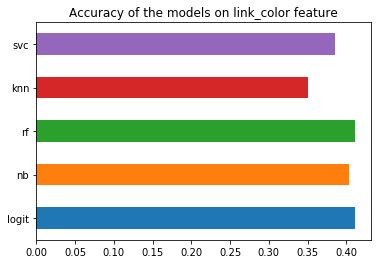

In [234]:
acc_model = pd.Series(acc_model, index = ['logit', 'nb', 'rf', 'knn', 'svc'])
acc_model.plot(kind = 'barh', title = 'Accuracy of the models on link_color feature')

### B. Evaluating the relationship between sidebar_color and user's gender

In [235]:
from sklearn import linear_model, metrics
from sklearn import naive_bayes
from sklearn.pipeline import make_pipeline

df_col = data.loc[:, ['gender:confidence', 'gender', 'sidebar_color']]

# Selecting rows where gender:confidence >= 1 and removing values like 7.60E+42
dfcolFiltered = df_col[(df_col['gender:confidence'] >= 1) & ((df_col['sidebar_color']).str.contains('E\+') != True)]

# splitting data into X and y

bow = bag_of_words_cal(dfcolFiltered['sidebar_color'])
X = bow

y = LabelEncoder().fit_transform(dfcolFiltered['gender'])

# Listing the classifiers I want to test the data on


In [236]:
X.shape

(13920, 473)

In [237]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state = 123)

In [238]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(9744, 473)
(4176, 473)
(9744,)
(4176,)


#### Baseline Model - sidebar_color

Calculating the baseline model by predicting the most frequently occuring gender class in the dataset. 

In [239]:
base_model = make_pipeline(CountVectorizer(analyzer=identity), DummyClassifier('most_frequent'))     
base_score = cross_val_score(base_model,dfcolFiltered['sidebar_color'], 
                             dfcolFiltered['gender'], cv=5, n_jobs=-1)

In [241]:
base_score.mean()

0.38527301050056195

The accuracy of baseline model is 38.52% 

#### Results for sidebar_color feature

In [242]:
results_sc =  pd.Series([eval_model(model) for model in models], 
                     index = ['logit', 'nb', 'rf', 'knn', 'svc'])

In [243]:
print(results_sc)

logit    0.410920
nb       0.403257
rf       0.411398
knn      0.349856
svc      0.385297
dtype: float64


It seems that Random Forest model is performing better when sidebar_color feature is used to predict the gender.

#### Plotting the bar plot for accuracies obtained for sidebar_color feature

In [244]:
mse_model = []
acc_model = []
for i in range(5):
    acc = results[i]
    acc_model.append(acc)

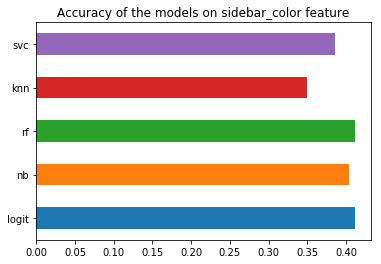

In [270]:
acc_model = pd.Series(acc_model, index = ['logit', 'nb', 'rf', 'knn', 'svc'])
acc_model.plot(kind = 'barh', title = 'Accuracy of the models on sidebar_color feature')

__Conclusion:__
It can be observed that all the models yield approximately the same accuracy around 30-42% for both the link_color and sidebar_color features. 41% is not significant improvement in prediction of user's gender since baseline model is predicting with 38% accuracy.

Hence, I would explore texts of the user to see if the texts are providing better results

## How well does tweets and profile descriptions predict users gender?

In [355]:
dfTextmod = dfText

### A. Considering only the description text collected from user's profile

In [256]:
bow = bag_of_words_cal(dfTextmod['desc_normalized'])
X = bow

y = LabelEncoder().fit_transform(dfTextmod['gender'])

#### Baseline Model

In [257]:
from cytoolz import identity
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
base_model_t = make_pipeline(CountVectorizer(analyzer=identity), DummyClassifier('most_frequent'))     
base_score_t = cross_val_score(base_model, dfTextmod['desc_normalized'], dfTextmod['gender'], cv=5, n_jobs=-1)

In [258]:
base_score_t.mean()

0.38888081981657974

The accuracy of baseline model is 38.88% 

#### Results for description feature used for predicting user gender

In [259]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state = 123)

In [260]:
results_dtext =  pd.Series([eval_model(model) for model in models], 
                     index = ['logit', 'nb', 'rf', 'knn', 'svc'])

In [261]:
print(results_dtext)

logit    0.620464
nb       0.626754
rf       0.581761
knn      0.415336
svc      0.388970
dtype: float64


Naive Bayes model is performing better with 62% accuracy

#### Plotting the accuracy barplot 

In [262]:
mse_model_text = []
acc_model_text = []
for i in range(5):
#     mse = results_text[i][0]
#     mse_model_text.append(mse)
    acc = results_text[i]#[1]
    acc_model_text.append(acc)

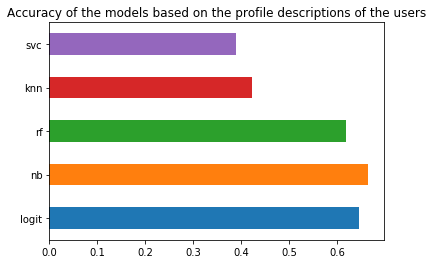

In [272]:
acc_model_text = pd.Series(acc_model_text, index = ['logit', 'nb', 'rf', 'knn', 'svc'])
acc_model_text.plot(kind = 'barh', title = 'Accuracy of the models based on the profile descriptions of the users')

### B. Considering only the Tweets text posted by the user

In [264]:
bow = bag_of_words_cal(dfTextmod['text_normalized'])
X = bow
### B. Considering only the Tweets text posted by the user
y = LabelEncoder().fit_transform(dfTextmod['gender'])

#### Baseline Model

In [265]:
from cytoolz import identity
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
base_model_t = make_pipeline(CountVectorizer(analyzer=identity), DummyClassifier('most_frequent'))     
base_score_t = cross_val_score(base_model, dfTextmod['text_normalized'], dfTextmod['gender'], cv=5, n_jobs=-1)

In [266]:
base_score_t.mean()

0.38888081981657974

The baseline model is performing with 38.88% accuracy

In [267]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state = 123)

#### Results for tweets feature used for predicting user gender

In [268]:
results_text =  pd.Series([eval_model(model) for model in models], 
                     index = ['logit', 'nb', 'rf', 'knn', 'svc'])

In [273]:
print(results_text)

logit    0.537494
nb       0.546202
rf       0.505322
knn      0.448960
svc      0.388970
dtype: float64


Naive bayes is performing better with 54.62% accuracy. However, if only text from the tweet is considered we are not getting good result when compared to results obtained from profile description text

#### Plotting bar plot for accuracy

In [274]:
mse_model_text = []
acc_model_text = []
for i in range(5):
#     mse = results_text[i][0]
#     mse_model_text.append(mse)
    acc = results_text[i]#[1]
    acc_model_text.append(acc)

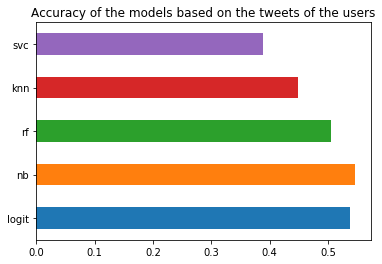

In [275]:
acc_model_text = pd.Series(acc_model_text, index = ['logit', 'nb', 'rf', 'knn', 'svc'])
acc_model_text.plot(kind = 'barh', title = 'Accuracy of the models based on the tweets of the users')

### C. Combining both description and tweets text together to evaluate the impact

In [248]:
bow = bag_of_words_cal(dfTextmod['all_text'])
X = bow

y = LabelEncoder().fit_transform(dfTextmod['gender'])

#### Baseline Model

In [249]:
from cytoolz import identity
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
base_model_t = make_pipeline(CountVectorizer(analyzer=identity), DummyClassifier('most_frequent'))     
base_score_t = cross_val_score(base_model, dfTextmod['all_text'], dfTextmod['gender'], cv=5, n_jobs=-1)

In [250]:
base_score_t.mean()

0.38888081981657974

The accuracy of baseline model after combining texts of both the profile description and tweets is 38.88% 

In [251]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state = 123)

#### Results for both the text (tweet and profile description)

In [252]:
results_text =  pd.Series([eval_model(model) for model in models], 
                     index = ['logit', 'nb', 'rf', 'knn', 'svc'])

In [253]:
print(results_text)

logit    0.645622
nb       0.664731
rf       0.617804
knn      0.422109
svc      0.388970
dtype: float64


Naive Bayes is performing best with 66% accuracy

#### Plotting bar plot for accuracy

In [254]:
mse_model_text = []
acc_model_text = []
for i in range(5):
#     mse = results_text[i][0]
#     mse_model_text.append(mse)
    acc = results_text[i]#[1]
    acc_model_text.append(acc)

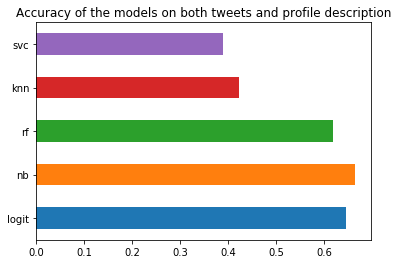

In [269]:
acc_model_text = pd.Series(acc_model_text, index = ['logit', 'nb', 'rf', 'knn', 'svc'])
acc_model_text.plot(kind = 'barh', title = 'Accuracy of the models on both tweets and profile description')

## Conclusion:
1. Naive Bayes model is performing better in predicting gender of the users.
2. Combining texts from tweet and profile description yeilds better accuracy when compared to considering text from each separately.
3. Text feature is better in predicting users' gender when compared to color features

## Recommendations:
1. The dataset has hyperlinks which contains users profile image. This image can be used to used to predict the gender of the user and may yield in better accuracy.
2. Taking more data regarding the tweets posted by the users may yeild in better results 